# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.


## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Plot showing distribution of images in train, validation, and test sets.
* Applied image augmentation
* Mapping of class indices for label prediction inference
* Creation and training of machine learning model.
* Saving the trained model.
* Plotting learning curve to visualize model performance..
* Evaluating model performance using a pickle file..
* Making predictions on a randomly chosen image file.




## Additional Comments | Insights | Conclusions

---

---

# Import regular packages

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [10]:
cwd= os.getcwd()

In [11]:
os.chdir('/workspace/pp5-mildew-detection')
print("You set a new current directory")

You set a new current directory


In [12]:
work_dir = os.getcwd()
work_dir

'/workspace/pp5-mildew-detection'

---

## Set input directories

Set train, validation and test paths

In [13]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [14]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('A prior version is in place; proceed with making a new version.')
    pass
else:
    os.makedirs(name=file_path)


A prior version is in place; proceed with making a new version.


## Set labels

In [15]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [16]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Count of Images in Train, Test, and Validation Datasets

* train - healthy: 736 images
* train - powdery_mildew: 736 images
* validation - healthy: 105 images
* validation - powdery_mildew: 105 images
* test - healthy: 211 images
* test - powdery_mildew: 211 images




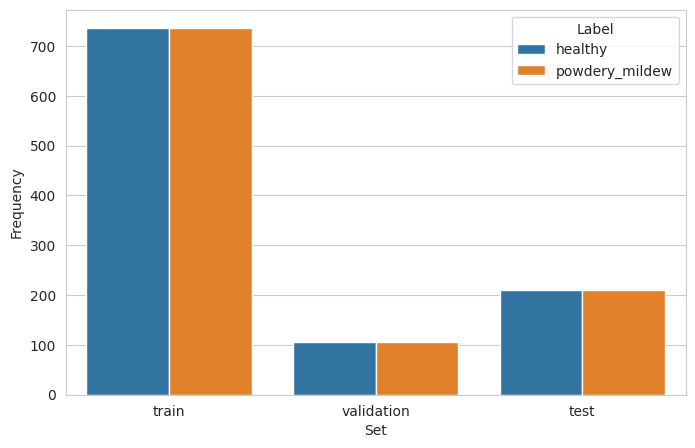

In [17]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [19]:
enhanced_img_data = ImageDataGenerator(rotation_range=20,
                                       width_shift_range=0.10,
                                       height_shift_range=0.10,
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='nearest',
                                       rescale=1./255
                                       )

* ### Augment training image dataset

In [20]:
batch_size = 1
train_set = enhanced_img_data.flow_from_directory(train_path,
                                                  target_size=image_shape[:2],
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='binary',
                                                  shuffle=True
                                                  )

train_set.class_indices

Found 1472 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [21]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 210 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [22]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 422 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(1, 256, 256, 3)


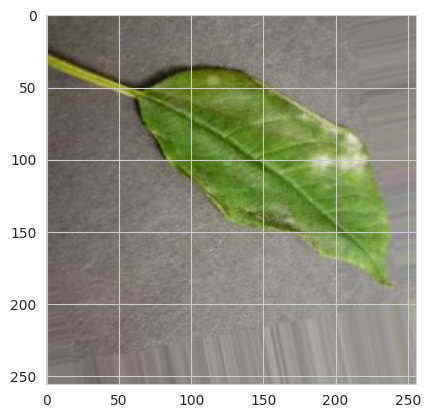

(1, 256, 256, 3)


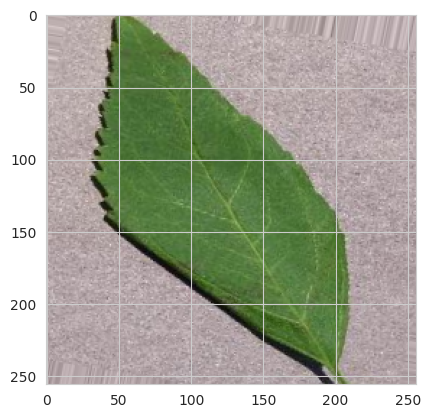

(1, 256, 256, 3)


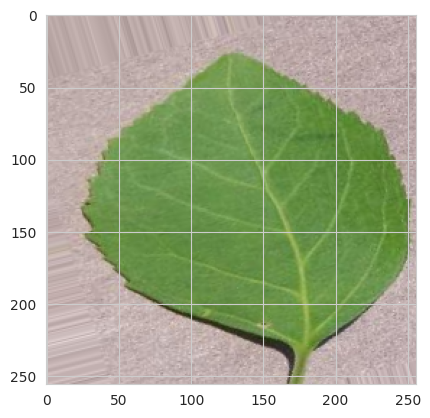

In [23]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(1, 256, 256, 3)


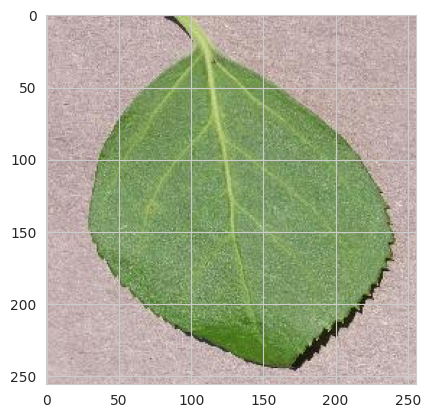

(1, 256, 256, 3)


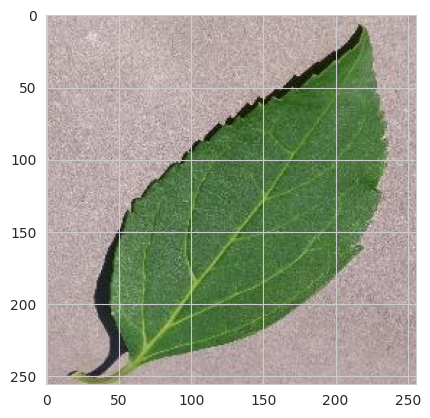

(1, 256, 256, 3)


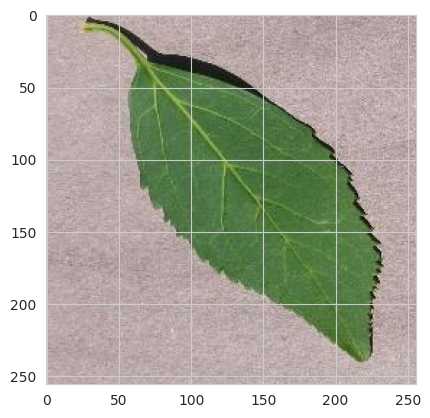

In [24]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape) 
    plt.imshow(img[0])
    plt.show()

(1, 256, 256, 3)


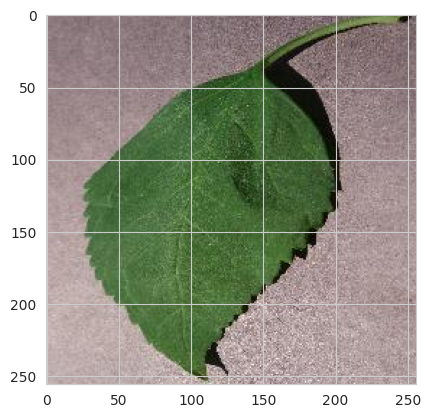

(1, 256, 256, 3)


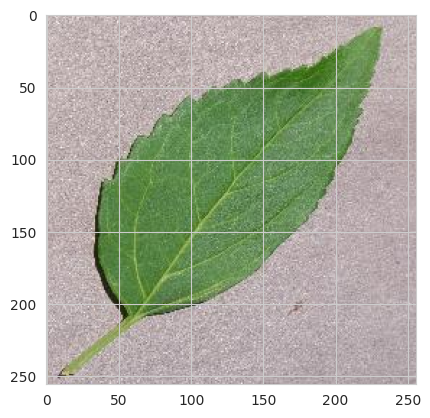

(1, 256, 256, 3)


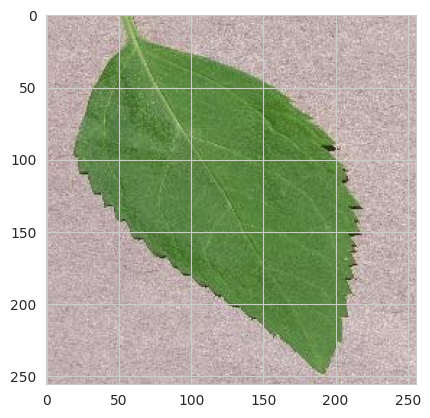

In [25]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [26]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---

* ### Import model packages

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [28]:
def tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
    
    # model.compile(loss='binary_crossentropy',
    #               optimizer='rmsprop',
    #               metrics=['accuracy'])

* ### Model Summary 

In [29]:
tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

2024-07-13 21:59:21.295369: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* ### Patience value (Early Stopping) 

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
stop_training = EarlyStopping(monitor='val_loss', patience=4)

## Fit model for model training

In [31]:
model = tf_model()
history = model.fit(
    train_set,
    epochs=12,
    steps_per_epoch=len(train_set.classes),
    validation_data=validation_set,
    callbacks=[stop_training],
    verbose=1
)

2024-07-13 21:59:21.484454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
1472/1472 [==============================] - 112s 76ms/step - loss: 0.6428 - accuracy: 0.7215 - val_loss: 0.0418 - val_accuracy: 0.9905
Epoch 2/12
1472/1472 [==============================] - 105s 71ms/step - loss: 0.2684 - accuracy: 0.8954 - val_loss: 0.3631 - val_accuracy: 0.8048
Epoch 3/12
1472/1472 [==============================] - 106s 72ms/step - loss: 0.1600 - accuracy: 0.9504 - val_loss: 0.0322 - val_accuracy: 0.9905
Epoch 4/12
1472/1472 [==============================] - 105s 71ms/step - loss: 0.1339 - accuracy: 0.9654 - val_loss: 0.0450 - val_accuracy: 0.9952
Epoch 5/12
1472/1472 [==============================] - 105s 71ms/step - loss: 0.1263 - accuracy: 0.9606 - val_loss: 0.0147 - val_accuracy: 0.9952
Epoch 6/12
1472/1472 [==============================] - 105s 72ms/step - loss: 0.0980 - accuracy: 0.9721 - val_loss: 0.0179 - val_accuracy: 0.9905
Epoch 7/12
1472/1472 [==============================] - 105s 71ms/step - loss: 0.0785 - accuracy: 0.9769 - val_loss: 0

## Save model

In [35]:
model.save('outputs/trained_model.h5')

---

# Model Performace

---

## Model learning curve

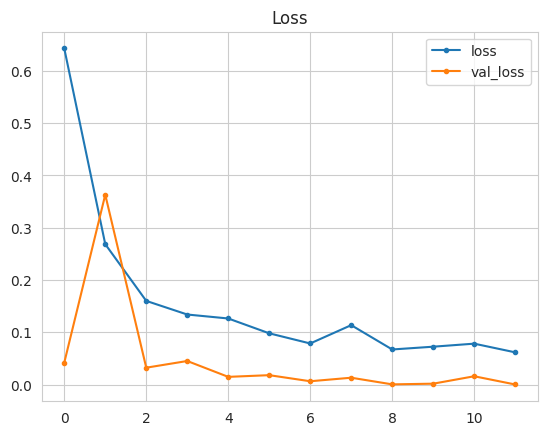

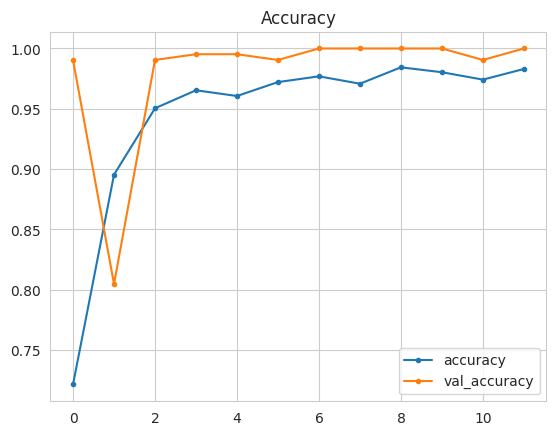

In [36]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()
